In [3]:
import numpy as np
% load_ext autoreload
% autoreload 2

from glob import glob
from models import pretrained
from rejectron.rejectronmodule import RejectronModule
from data.camelyon import CamelyonModule
import pytorch_lightning as pl
from scipy.stats import binom_test

In [15]:
loc = '/voyager/projects/tomginsberg/detectron/checkpoints/camelyon/rejectron_test_seed=0_test_samples=1_shift=True'
h = pretrained.camelyon_model(seed=0, wilds=False)

In [16]:
rm = RejectronModule(h)
rm.load_from_directory(loc)

Loading 2 checkpoints from /voyager/projects/tomginsberg/detectron/checkpoints/camelyon/rejectron_test_seed=0_test_samples=1_shift=True using class <class 'models.classifier.TorchvisionClassifier'>


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/it]


In [17]:
dm = CamelyonModule(
    negative_labels=False
)
dm.configure_test_set(test_seed=0,
                      test_samples=9,
                      shift=True, exclusion_seed=0, exclusion_amount=1)

In [18]:
import pandas as pd

In [19]:
tr = pl.Trainer(gpus=[3])
tr.validate(rm, dm.predict_dataloader(), verbose=False)
baseline_rejection = rm.get_val_stats()['rejection'].item()
print(baseline_rejection, 'baseline rejection')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Validating: 0it [00:00, ?it/s]

/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
l = []
test_samples = 9
exclusion_amount = 1
exclusion_seed = 0

for shift in (False,):
    for i in range(100):
        dm.configure_test_set(test_seed=i,
                              test_samples=test_samples,
                              shift=shift, exclusion_seed=exclusion_seed, exclusion_amount=exclusion_amount)
        tr = pl.Trainer(gpus=[3])
        tr.validate(rm, dm.test_dataloader(), verbose=False)
        stats = rm.get_val_stats()
        pval = binom_test(round(stats['rejection'].item() * test_samples), test_samples, baseline_rejection,
                          alternative='greater')

        l.append(dict(rejection=stats['rejection'].item(), test_seed=i,
                      test_samples=test_samples, samples=test_samples,
                      shift=shift, exclusion_seed=exclusion_seed, exclusion_amount=exclusion_amount,
                      accepted_acc=stats['accepted_acc'].item(),
                      rejected_acc=stats['rejected_acc'].item(), global_acc=stats['global_acc'].item(),
                      pval=pval, significant=pval < 0.05))

df_f = pd.DataFrame(l)

In [33]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
td = [(df.query('shift==True').pval < i).mean() for i in np.arange(0, 1, 0.001)]
fd = [(df_f.query('shift==False').pval < i).mean() for i in np.arange(0, 1, 0.001)]

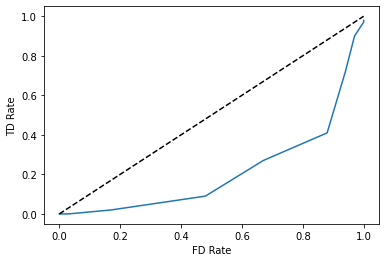

In [45]:
plt.plot(fd, td)
plt.ylabel('TD Rate')
plt.xlabel('FD Rate')
plt.plot([0, 1], [0, 1], 'k--')

In [46]:
np.trapz(td, fd)

0.2103